In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from tabulate import tabulate
from scipy.interpolate import UnivariateSpline

In [2]:
def plot_scientific_debt(projects_to_keep, introduced_counts, removed_counts):
    # Create a figure with subplots for each project
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))
    fig.suptitle('Introduction and Removal Trends of Scientific Self-Admitted Technical Debt (SATD) Comments', fontsize=16)

    # Store handles for legend
    handles, labels = None, None

    # Plot normalized data for each project
    for idx, project in enumerate(projects_to_keep):
        ax = axes[idx // 3, idx % 3]

        # Get the data for the project
        introduced_data = introduced_counts.xs(project, level='project')
        removed_data = removed_counts.xs(project, level='project')
        
        # Filter to include only the "scientific debt" category
        if "scientific debt" in introduced_data.columns and "scientific debt" in removed_data.columns:
            introduced_data = introduced_data[["scientific debt"]]
            removed_data = removed_data[["scientific debt"]]
        else:
            introduced_data = pd.DataFrame(columns=["scientific debt"])  # Create an empty DataFrame if no data for scientific debt
            removed_data = pd.DataFrame(columns=["scientific debt"])  # Create an empty DataFrame if no data for scientific debt
        
        # Apply rolling mean for smoothing
        introduced_data_smooth = introduced_data.apply(lambda x: UnivariateSpline(range(len(x)), x, s=1)(range(len(x))), axis=0)
        removed_data_smooth = removed_data.apply(lambda x: UnivariateSpline(range(len(x)), x, s=1)(range(len(x))), axis=0)
        
        # Apply category-specific color for scientific debt
        introduced_plot_color = '#FF0000'  # Red for introduction
        removed_plot_color = '#0000FF'  # Blue for removal

        # Plot the data
        intro_line = introduced_data_smooth.plot(kind='line', marker='o', color=introduced_plot_color, ax=ax, label='Introduction', legend=False)
        rem_line = removed_data_smooth.plot(kind='line', marker='x', color=removed_plot_color, ax=ax, label='Removal', legend=False)
        
        # Collect handles and labels for the legend
        if handles is None and labels is None:
            handles, labels = ax.get_legend_handles_labels()

        ax.set_title(f'{project}')
        ax.set_xlabel('Year')
        if idx % 3 == 0:
            ax.set_ylabel("Normalized Count")
        ax.grid(True)

    # Create a single legend for the entire figure
    fig.legend(handles, ['Introduction', 'Removal'], loc='upper right', title='Type')

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the title
    plt.show()

def plot_scientific_debt_percentages(df, color_map):
    """
    Plots stacked bar charts showing the percentages of scientific debt categories for each project.

    Args:
        df (pd.DataFrame): DataFrame containing the project and scientific category data.
        color_map (dict): Dictionary mapping scientific categories to colors.
    """
    # Calculate the percentage of each category within each project
    category_counts = df.groupby(['project', 'scientific_category']).size().unstack(fill_value=0)
    category_percentages = category_counts.div(category_counts.sum(axis=1), axis=0) * 100

    # Plot the stacked bar chart for each project
    fig, ax = plt.subplots(figsize=(12, 8))

    # Sort the columns based on the order in color_map
    sorted_columns = sorted(category_percentages.columns, key=lambda x: list(color_map.keys()).index(x))
    category_percentages = category_percentages[sorted_columns]

    print(tabulate(category_percentages, headers='keys', tablefmt='psql', showindex=True))

    # Plot the data
    category_percentages.plot(kind='bar', stacked=True, color=[color_map[cat] for cat in sorted_columns], ax=ax)

    ax.set_title('Scientific Debt Indicator Percentages by Project')
    ax.set_xlabel('project')
    ax.set_ylabel('Percentage')
    ax.legend(title='Indicator', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [3]:
# Define the sequence of debt categories
debt_sequence = [
    'code debt',
    'design debt',
    'architectural debt',
    'build debt',
    'defect debt',
    'documentation debt',
    'requirements debt',
    'test debt',
    'on hold debt',
    'algorithm debt',
    'scientific debt',
]

category_color_map = {
    'algorithm debt': '#1f77b4',
    'architectural debt': '#ff7f0e',
    'build debt': '#2ca02c',
    'code debt': '#9467bd',
    'defect debt': '#d62728',
    'design debt': '#8c564b',
    'documentation debt': '#e377c2',
    'on hold debt': '#7f7f7f',
    'requirements debt': '#bcbd22',
    'scientific debt': '#17becf',
    'test debt': '#1a55FF',
}

scientific_color_map = {
    'assumptions': '#e41a1c',  # Red
    'missing edge case': '#377eb8',  # Blue
    'computational accuracy': '#4daf4a',  # Green
    'translation challenges': '#984ea3',  # Purple
    'new scientific findings': '#ff7f00',  # Orange
}

In [4]:
df = pd.read_csv("ssw_satd.csv")

# Define the list of columns to keep
columns_to_keep = ['file_name', 'comment', 'project', 'category', 'scientific_category', 'introduced', 'removed']

# Drop columns that are not in the list
df = df[columns_to_keep]

print(df.columns)

Index(['file_name', 'comment', 'project', 'category', 'scientific_category',
       'introduced', 'removed'],
      dtype='object')


In [5]:
df['scientific_category'] = df['scientific_category'].str.replace('"', '')
df['scientific_category'] = df['scientific_category'].replace('scientific findings', 'new scientific findings')

## All Categories

+-----------+------------------+----------------------+--------------+-------------+---------------+---------------+----------------------+----------------+---------------------+-------------------+-------------+
| project   |   algorithm debt |   architectural debt |   build debt |   code debt |   defect debt |   design debt |   documentation debt |   on hold debt |   requirements debt |   scientific debt |   test debt |
|-----------+------------------+----------------------+--------------+-------------+---------------+---------------+----------------------+----------------+---------------------+-------------------+-------------|
| Astropy   |          7.47625 |              4.21314 |     1.65221  |     34.6964 |      10.7807  |       11.3176 |              3.42834 |        4.04791 |             4.7501  |           9.04585 |     8.59149 |
| Athena    |          4.06464 |              6.85602 |     2.07313  |     31.9621 |      10.6268  |       17.9236 |              3.95038 |        7

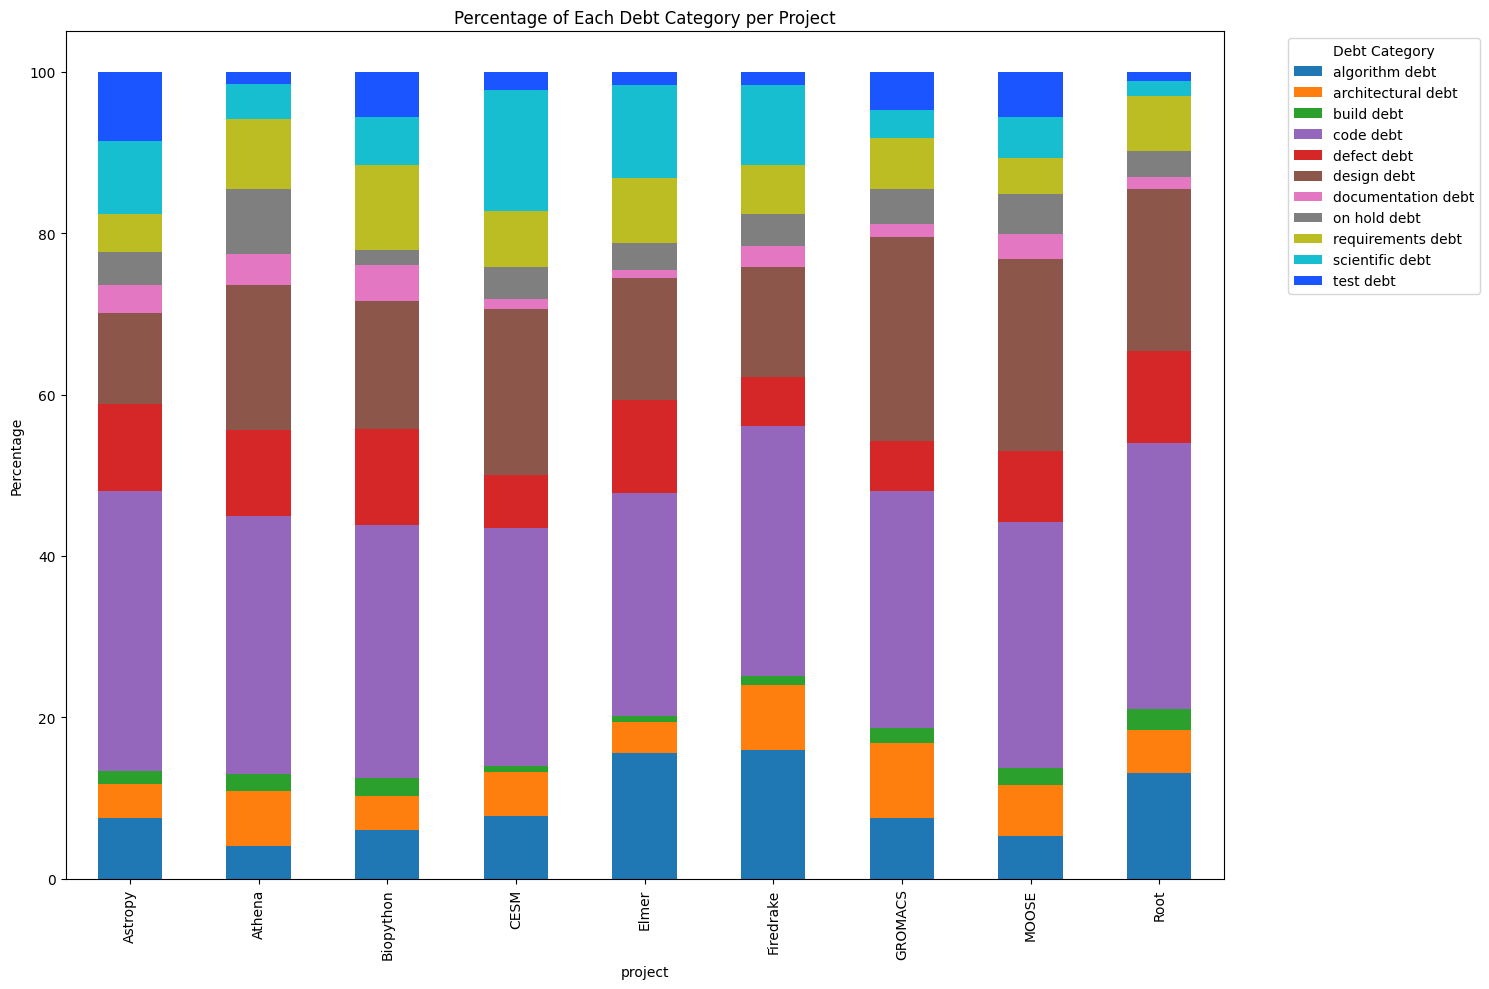

In [6]:
# Convert 'category' values to lower case and strip whitespace
df['category'] = df['category'].str.lower().str.strip()

# Split 'category' values and create a new dataframe for exploded categories
exploded_df = df.assign(category=df['category'].str.split(', ')).explode('category')

# Strip whitespace from individual categories in the exploded dataframe
exploded_df['category'] = exploded_df['category'].str.strip()

# Count the occurrences of each category per project
category_counts = exploded_df.groupby(['project', 'category']).size().unstack(fill_value=0)

# Calculate percentages
category_percentages = category_counts.div(category_counts.sum(axis=1), axis=0) * 100

# Plotting
fig, ax = plt.subplots(figsize=(15, 10))

# Create a stacked bar plot
# Ensure all categories in the color map
category_colors = [category_color_map[cat] for cat in category_counts.columns if cat in category_color_map]
category_percentages[category_color_map.keys()].plot(kind='bar', stacked=True, color=category_colors, ax=ax)

print(tabulate(category_percentages, headers='keys', tablefmt='psql', showindex=True))

# Set labels and title
ax.set_xlabel('project')
ax.set_ylabel('Percentage')
ax.set_title('Percentage of Each Debt Category per Project')
ax.legend(title='Debt Category', bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.tight_layout()
plt.show()

## Scientific Categories

+-----------+---------------+---------------------+--------------------------+--------------------------+---------------------------+
| project   |   assumptions |   missing edge case |   computational accuracy |   translation challenges |   new scientific findings |
|-----------+---------------+---------------------+--------------------------+--------------------------+---------------------------|
| Astropy   |       22.7273 |             30.6818 |                 31.25    |                 14.2045  |                  1.13636  |
| Athena    |       27.8008 |             28.6307 |                 14.9378  |                 20.332   |                  8.29876  |
| Biopython |       26.6667 |             33.3333 |                 10.6667  |                 20       |                  9.33333  |
| CESM      |       34.402  |             26.5105 |                 21.2084  |                 13.6868  |                  4.19236  |
| Elmer     |       26.9231 |             33.3333 |           

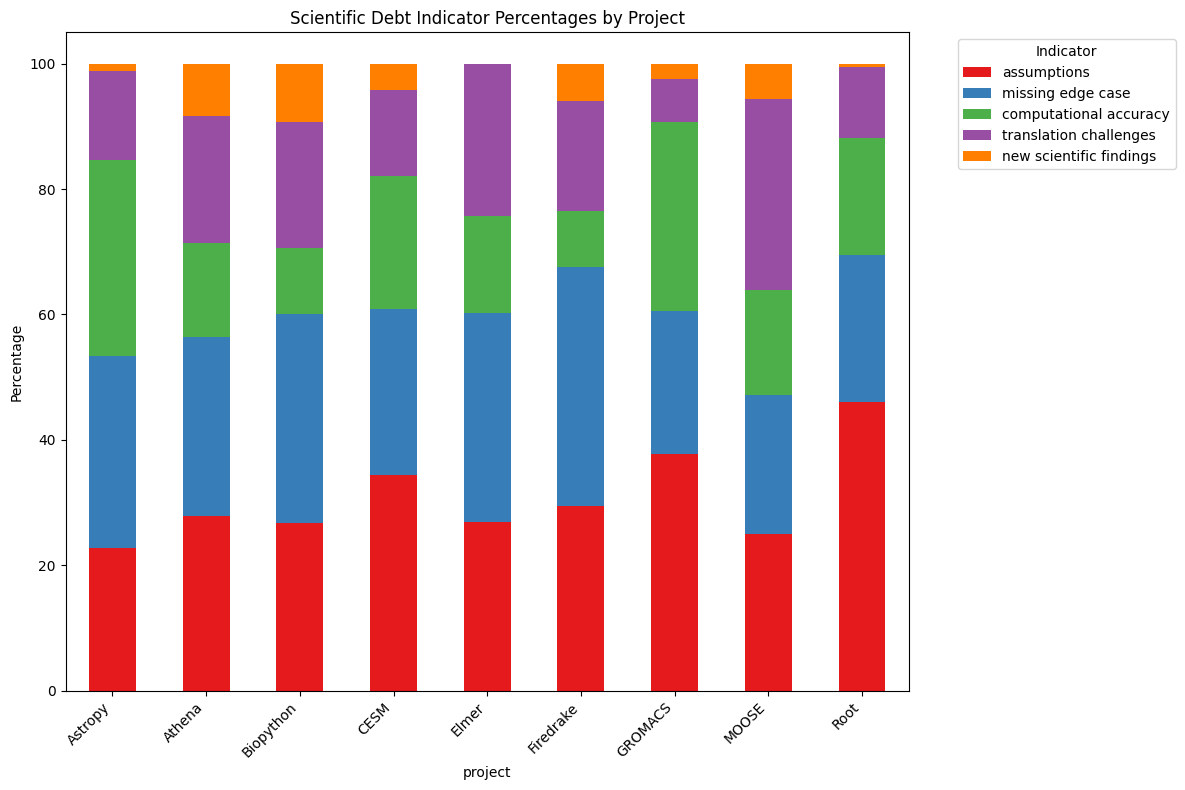

In [7]:
plot_scientific_debt_percentages(df, scientific_color_map)

## Introduction and Removal

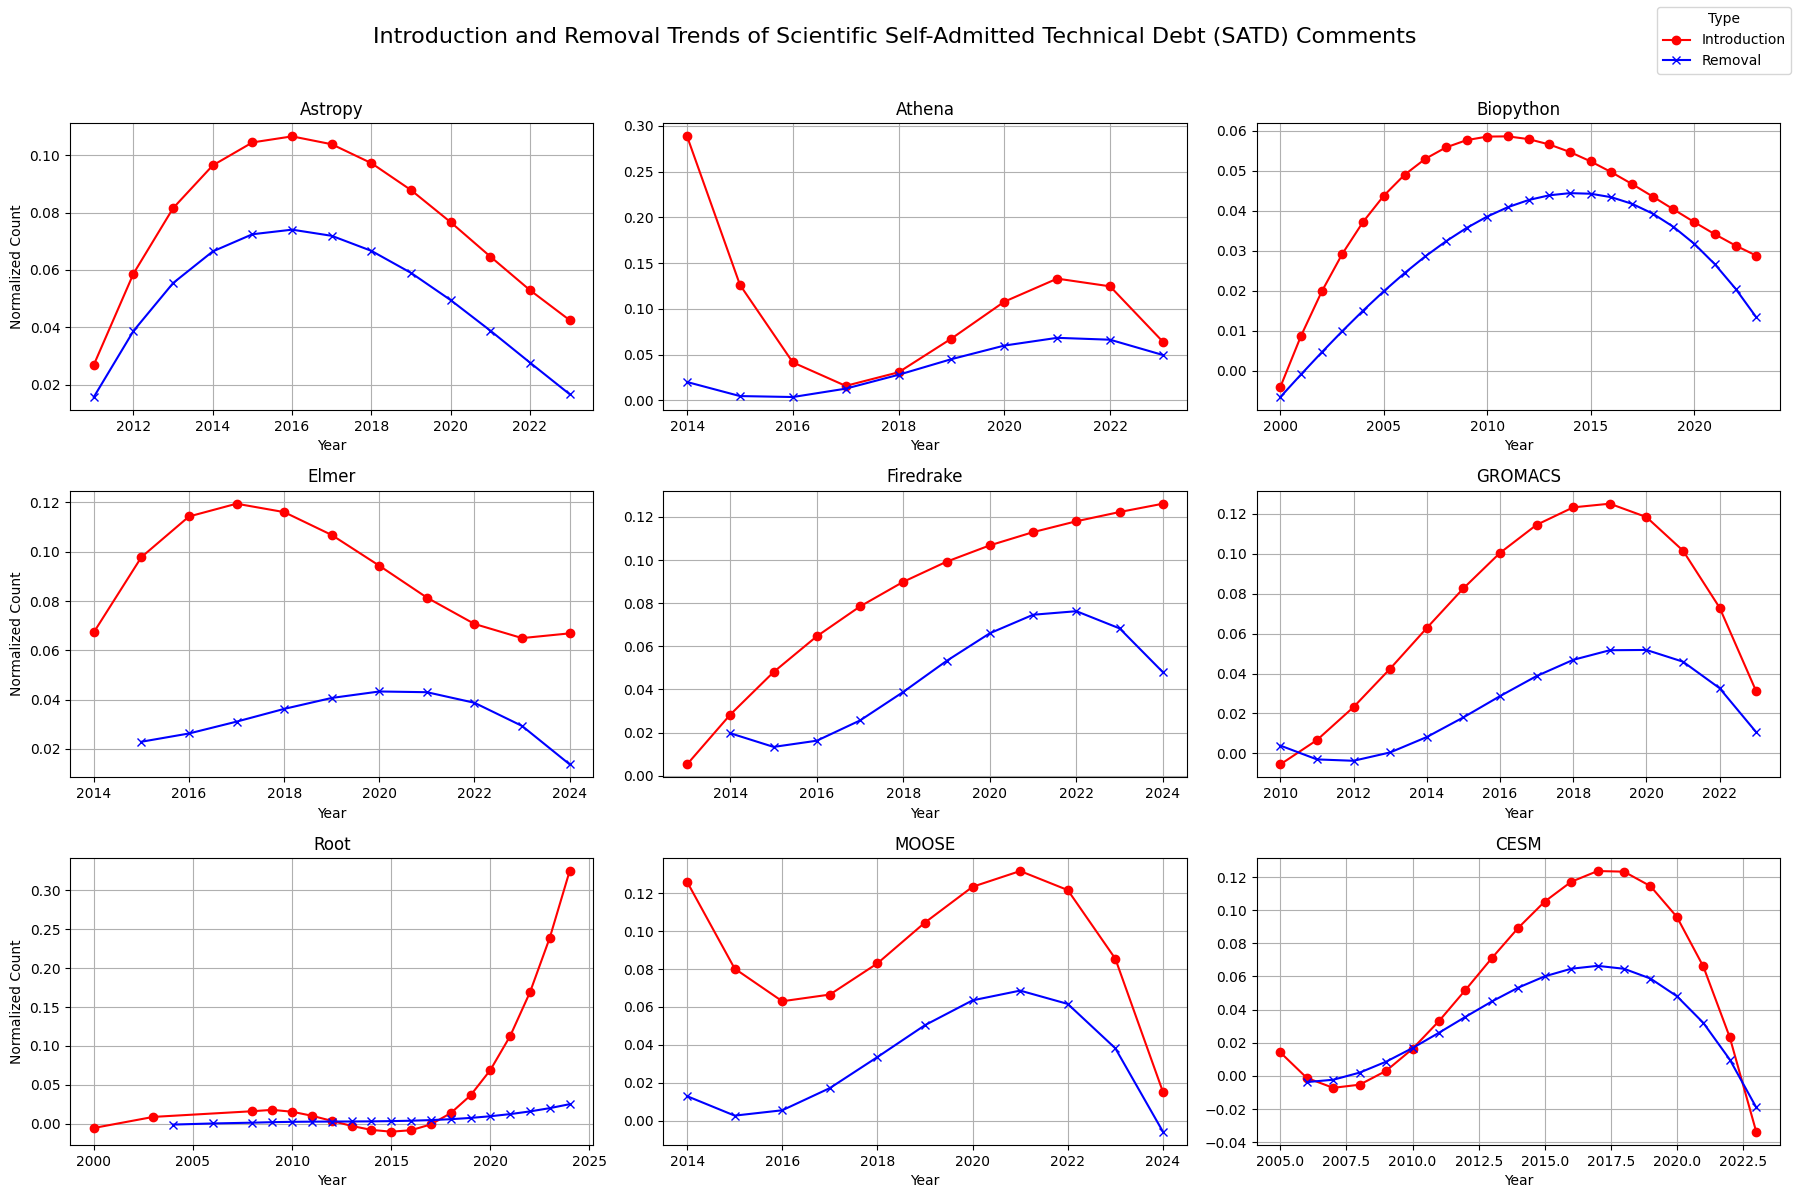

In [8]:
# Load and prepare the data
df = pd.read_csv("ssw_satd.csv")
columns_to_keep = ['file_name', 'comment', 'project', 'category', 'scientific_category', 'introduced', 'removed']
df = df[columns_to_keep]
df['scientific_category'] = df['scientific_category'].str.replace('"', '')
df = df.dropna(subset=['category'])

# Filter projects
projects_to_keep = ["Astropy", "Athena", "Biopython", "Elmer", "Firedrake", "GROMACS", "Root", "MOOSE", "CESM"]
df.loc[~df['project'].isin(projects_to_keep), 'project'] = "CESM"

# Process introduction dates
df['introduced'] = pd.to_datetime(df['introduced'], utc=True, errors='coerce')
df['Introduced_Year'] = df['introduced'].dt.year
df = df.dropna(subset=['Introduced_Year'])
df['Introduced_Year'] = df['Introduced_Year'].astype(int)

# Explode categories
df['category'] = df['category'].astype(str).str.replace(' ', '').str.split(',')
df_exploded = df.explode('category')
df_exploded['category'] = df_exploded['category'].str.replace('debt', ' debt').str.replace('hold', ' hold')

# Calculate total counts by category and project
total_counts_by_category_project = df_exploded.groupby(['project', 'category']).size().unstack(fill_value=0)

# Calculate introduced counts
introduced_counts = df_exploded.groupby(['Introduced_Year', 'project', 'category']).size().unstack(fill_value=0)
introduced_counts = introduced_counts.reindex(columns=total_counts_by_category_project.columns, fill_value=0)

# Normalize introduced counts by total counts
introduced_counts_normalized_by_category = introduced_counts.div(total_counts_by_category_project, axis=1, level=1)

# Process removal dates
df['removed'] = pd.to_datetime(df['removed'], utc=True, errors='coerce')
df['Removed_Year'] = df['removed'].dt.year
df = df.dropna(subset=['Removed_Year'])
df['Removed_Year'] = df['Removed_Year'].astype(int)

# Explode categories for removal data
df_exploded = df.explode('category')
df_exploded['category'] = df_exploded['category'].str.replace('debt', ' debt').str.replace('hold', ' hold')

# Calculate removed counts
removed_counts = df_exploded.groupby(['Removed_Year', 'project', 'category']).size().unstack(fill_value=0)
removed_counts = removed_counts.reindex(columns=total_counts_by_category_project.columns, fill_value=0)

# Normalize removed counts by total counts
removed_counts_normalized = removed_counts.div(total_counts_by_category_project, axis=1, level=1)

# # Plot the data
plot_scientific_debt(projects_to_keep, introduced_counts_normalized_by_category, removed_counts_normalized)

In [9]:
# Load and prepare the data
df = pd.read_csv("ssw_satd.csv")
columns_to_keep = ['file_name', 'comment', 'project', 'category', 'scientific_category', 'introduced', 'removed']
df = df[columns_to_keep]
df['scientific_category'] = df['scientific_category'].str.replace('"', '')
df['scientific_category'] = df['scientific_category'].replace('scientific findings', 'new scientific findings')
df = df.dropna(subset=['category'])

# Function to calculate percentages and sort them
def calculate_category_percentages(df):
    total_counts = df['scientific_category'].value_counts()
    
    addressed_counts = df[df['removed'].notna()]['scientific_category'].value_counts()
    addressed_percentages = (addressed_counts / total_counts) * 100
    addressed_percentages = addressed_percentages.sort_values(ascending=False)
    
    unaddressed_counts = df[df['removed'].isna()]['scientific_category'].value_counts()
    unaddressed_percentages = (unaddressed_counts / total_counts) * 100
    unaddressed_percentages = unaddressed_percentages.sort_values(ascending=False)
    
    return addressed_percentages, unaddressed_percentages

# Calculate the percentages
addressed_percentages, unaddressed_percentages = calculate_category_percentages(df)

# Print the results
print("Percentage of 'scientific_category' mostly addressed (sorted):")
print(addressed_percentages)

print("\nPercentage of 'scientific_category' mostly unaddressed (sorted):")
print(unaddressed_percentages)

Percentage of 'scientific_category' mostly addressed (sorted):
scientific_category
new scientific findings    54.929577
computational accuracy     53.571429
missing edge case          50.414938
translation challenges     44.736842
assumptions                41.379310
Name: count, dtype: float64

Percentage of 'scientific_category' mostly unaddressed (sorted):
scientific_category
assumptions                58.620690
translation challenges     55.263158
missing edge case          49.585062
computational accuracy     46.428571
new scientific findings    45.070423
Name: count, dtype: float64
